In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

In [8]:
class CityTrafficSimulation:
    def __init__(self, radius, n_users):
        self.radius = radius
        self.n_users = n_users
        self.G = self.create_hexagonal_network()
        #if gravity_model:
            #self.paths = self.generate_paths_gravity()
        #else:
        self.paths = self.generate_paths()

    def hexagon_mask(self, x, y):
        """
        Return True if the point (x, y) is within a hexagon of given radius
        """
        return np.abs(x) <= self.radius and np.abs(y) <= self.radius and np.abs(x + y) <= self.radius
    
    def create_hexagonal_network(self):
        """
        Return the hexagonal undirected network of given radius with triangular lattice
        """
        G = nx.Graph()
        # Create the triangular lattice
        for x in range(-self.radius, self.radius + 1):
            for y in range(-self.radius, self.radius + 1):
                if self.hexagon_mask(x, y):
                    # Add the node
                    G.add_node((x, y))
                    # Add edges to neighbors
                    neighbors = [(x + 1, y), (x, y + 1), (x - 1, y + 1)]
                    for nx_, ny_ in neighbors:
                        if self.hexagon_mask(nx_, ny_):
                            G.add_edge((x, y), (nx_, ny_))
                            #G.add_edge((nx_, ny_), (x, y))
        return G
    
    """
    def plot_network(self):
        #Plot the hexagonal network
        pos = {node: (node[0] + 0.5 * node[1], node[1] * np.sqrt(3)/2) for node in self.G.nodes()}
        plt.figure(figsize=(6, 5))
        nx.draw(self.G, pos, node_size=100, node_color='lightblue', edge_color='gray', with_labels=True)
        plt.title(f'Radius={self.radius}')
        plt.show()
    """

    def generate_paths(self):
        """
        Generate random O-D points and connect them by unweighted (all links have the same weight) shortest paths.
        The output is the paths of edges.
        """
        paths = []
        node_map = list(self.G)
        num_nodes = self.G.number_of_nodes()
        OD_matrix = np.zeros((len(node_map), len(node_map)))
        for _ in range(self.n_users):
            origin_node_idx, destination_node_idx = np.random.randint(0, num_nodes, 2)
            if origin_node_idx == destination_node_idx:
                destination_node_idx = np.random.randint(0, num_nodes)
            origin_node = node_map[origin_node_idx]
            destination_node = node_map[destination_node_idx]
            OD_matrix[origin_node_idx, destination_node_idx] += 1
            path_of_nodes = nx.dijkstra_path(self.G, origin_node, destination_node)
            path_of_edges = [(path_of_nodes[edge], path_of_nodes[edge+1]) for edge in range(len(path_of_nodes)-1)]
            paths.append(path_of_edges)
        return paths, OD_matrix

In [9]:
class CityTrafficSimulationGravity:
    def __init__(self, radius, n_users):
        self.radius = radius
        self.n_users = n_users
        self.G = self.create_hexagonal_network()
        #if gravity_model:
            #self.paths = self.generate_paths_gravity()
        #else:
        self.paths = self.generate_paths()

    def hexagon_mask(self, x, y):
        """
        Return True if the point (x, y) is within a hexagon of given radius
        """
        return np.abs(x) <= self.radius and np.abs(y) <= self.radius and np.abs(x + y) <= self.radius
    
    def create_hexagonal_network(self):
        """
        Return the hexagonal undirected network of given radius with triangular lattice
        """
        G = nx.Graph()
        # Create the triangular lattice
        for x in range(-self.radius, self.radius + 1):
            for y in range(-self.radius, self.radius + 1):
                if self.hexagon_mask(x, y):
                    # Add the node
                    G.add_node((x, y))
                    # Add edges to neighbors
                    neighbors = [(x + 1, y), (x, y + 1), (x - 1, y + 1)]
                    for nx_, ny_ in neighbors:
                        if self.hexagon_mask(nx_, ny_):
                            G.add_edge((x, y), (nx_, ny_))
                            #G.add_edge((nx_, ny_), (x, y))
        return G
    
    """
    def plot_network(self):
        #Plot the hexagonal network
        pos = {node: (node[0] + 0.5 * node[1], node[1] * np.sqrt(3)/2) for node in self.G.nodes()}
        plt.figure(figsize=(6, 5))
        nx.draw(self.G, pos, node_size=100, node_color='lightblue', edge_color='gray', with_labels=True)
        plt.title(f'Radius={self.radius}')
        plt.show()
    """

    def gravity_model(self):
        nodes = list(self.G.nodes())
        attractiveness = {node: random.uniform(1, 10) for node in nodes}  # Random attractiveness factor
        trips = []
        for origin in nodes:
            for destination in nodes:
                if origin != destination:
                    distance = nx.shortest_path_length(self.G, origin, destination)
                    probability = (attractiveness[origin] * attractiveness[destination]) / (distance ** 2 + 1e-5)
                    trips.append((origin, destination, probability))
        return trips

    def generate_paths(self):
        """
        Generate random O-D points and connect them by unweighted (all links have the same weight) shortest paths.
        The output is the paths of edges.
        """
        paths = []
        trips = self.gravity_model()
        nod_idx_dict = {nod:idx for idx, nod in enumerate(self.G.nodes())}
        OD_matrix = np.zeros((len(nod_idx_dict), len(nod_idx_dict)))
        total_prob = sum(trip[2] for trip in trips)
        trips = [(o, d, p / total_prob) for o, d, p in trips]  # Normalize probabilities
        origins, destinations, probabilities = zip(*trips)
        chosen_trips = random.choices(list(zip(origins, destinations)), weights=probabilities, k=self.n_users)
        for trip in chosen_trips:
            OD_matrix[nod_idx_dict[trip[0]], nod_idx_dict[trip[1]]] += 1
            path_of_nodes = nx.dijkstra_path(self.G, trip[0], trip[1])
            path_of_edges = [(path_of_nodes[edge], path_of_nodes[edge+1]) for edge in range(len(path_of_nodes)-1)]
            paths.append(path_of_edges)
        return paths, OD_matrix

In [10]:
class Congestion:
    def __init__(self, paths, edge_capacity, t_block):
        self.paths = paths
        self.edge_capacity = edge_capacity
        self.t_block = t_block
        #seld.edge_counts = self.count_transport_edge()
        self.congestion_ratio = self.congestion_points()

    def count_transport_edge(self):
        """
        Count the number of users passing through an edge. Return a tuple with the edge (key) and number (value)
        """
        tuple_counts = {}

        for i, path1 in enumerate(self.paths):
            for edge in path1:
                if edge not in tuple_counts:
                    tuple_counts[edge] = 1
                for j, path2 in enumerate(self.paths):
                    if i != j:
                        tuple_counts[edge] += path2.count(edge)
        return tuple_counts
    
    def congestion_points(self):
        """
        Determine the congestion level of each edge using the volume-over-capacity ratio 
        """ 
        # Count the number of users passing through each edge
        tuple_counts = self.count_transport_edge()

        # Determine the congestion edges
        congestion_ratios = {}
        for i, j in enumerate(tuple_counts):
            congestion_ratio = list(tuple_counts.values())[i] / self.edge_capacity
            congestion_ratios[j] = congestion_ratio
        return congestion_ratios
    
    def baseline_CT(self):
        """
        COMPUTE THE BASELINE COMMUTING TIME
        Considering that the velocity decreases linearly until reach the congestion
        """
        baselines = []
        for path in self.paths:
            baseline = len(path) * self.t_block #t_block units (minutes)
            baselines.append(baseline)
        return baselines #minutes

    def direct_CT(self, penalty):
        """
        COMPUTE THE DIRECT COMMUTING TIME
        congestion_ratio -> dictionary
        penalty -> give in seconds
        """ 
        #congestion_points = [key for key, value in self.congestion_ratio.items() if value > 0.8]
        congested_time = []
        for tuple in self.paths:
            c = 0
            for edge in tuple:
                #if edge in congestion_points:
                c += penalty * self.congestion_ratio[edge] #sec
            congested_time.append(c/60) #minutes
        return congested_time #direct_cost in minutes
    
    def direct_CT_RecomputingTime(self, alpha=0.15, beta=4):
        """
        congestion_ratio -> dictionary
        t_block -> give in minutes
        """

        new_times = {key: ((self.t_block*(1+alpha*(value)**beta)) - self.t_block) for key, value in self.congestion_ratio.items()} #t_block units (minutes)
        # Compute the time for each path
        direct = []
        for path in self.paths:
            c = 0
            for edge in path:
                c += new_times[edge]
            direct.append(c) 
        return direct # minutes

    def indirect_CT(self, other_method_paths, penalty=0.1):
        """
        COMPUTE THE INDIRECT COMMUTING TIME
        """
        indirect = []
        for tuple in other_method_paths:
            c = 0
            for edge in tuple:
                if (edge in list(self.congestion_ratio.keys())) and (self.congestion_ratio[edge] < 0.6):
                    c += 0 * penalty #sec
                elif (edge in list(self.congestion_ratio.keys())) and (self.congestion_ratio[edge] < 0.7):
                    c += 1 * penalty #sec
                elif (edge in list(self.congestion_ratio.keys())) and (self.congestion_ratio[edge] < 0.8):
                    c += 2 * penalty #sec
                elif (edge in list(self.congestion_ratio.keys())) and (self.congestion_ratio[edge] < 0.9):
                    c += 3 * penalty #sec
                elif (edge in list(self.congestion_ratio.keys())) and (self.congestion_ratio[edge] < 1.0):
                    c += 4 * penalty #sec
                elif (edge in list(self.congestion_ratio.keys())) and (self.congestion_ratio[edge] > 1.0):
                    c += 5 * penalty #sec
                else:
                    continue
            indirect.append(c/60)
        return indirect #minutes

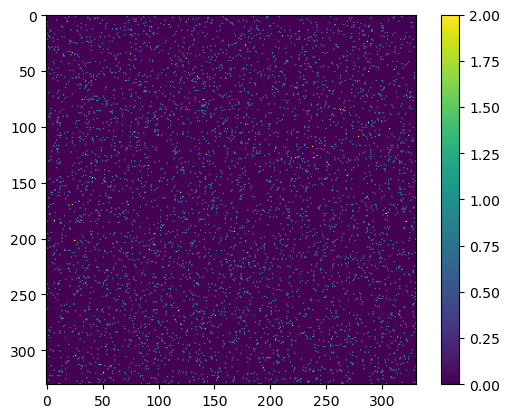

In [ ]:
# OD matrix: randomly generated
bike_edges_paths, OD_bike = CityTrafficSimulation(radius=10, n_users=5000).generate_paths()

plt.imshow(OD_bike)
plt.colorbar()


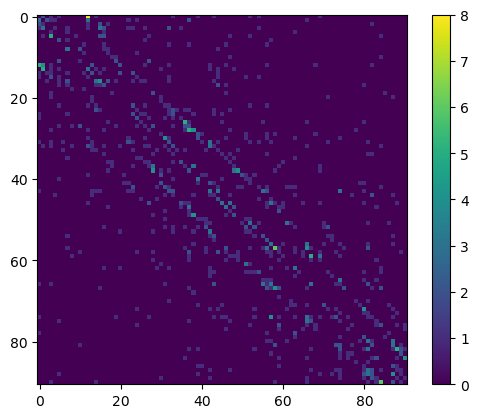

In [ ]:
# OD matrix: generated by gravity model
bike_edges_paths, OD_bike = CityTrafficSimulationGravity(radius=5, n_users=1000).generate_paths()

plt.imshow(OD_bike)
plt.colorbar()

In [48]:
np.sum(OD_bike, axis=1)

array([19., 15.,  8., 19.,  4., 15.,  5.,  6.,  8.,  3.,  4.,  7., 21.,
       16., 13., 10., 19., 10.,  2.,  6.,  5.,  2., 10., 12., 12.,  7.,
       12., 14., 16.,  8., 15., 19., 19., 11.,  8.,  6.,  9., 13., 18.,
       10.,  8., 11., 15., 25., 13.,  6., 23., 14.,  5.,  9.,  6., 14.,
       15.,  9., 10.,  4., 12., 26., 18., 17.,  8.,  5., 11., 11.,  3.,
        8., 19., 17.,  1.,  1.,  4.,  9., 12.,  4., 25., 10., 12.,  6.,
        5.,  5., 11., 14., 19.,  6., 13.,  2.,  7., 14., 17., 10., 15.])

In [19]:
bike_edges_paths = CityTrafficSimulation(radius=10, n_users=150).generate_paths()
car_edges_paths = CityTrafficSimulation(radius=10, n_users=200).generate_paths()

In [20]:
C_bike = Congestion(bike_edges_paths, 120, 0.5)
C_car = Congestion(car_edges_paths, 50, 0.2)

In [31]:
baseline_cost = [np.mean(C_bike.baseline_CT()), np.mean(C_car.baseline_CT())]
direct_cost = [np.mean(C_bike.direct_CT(0.1)), np.mean(C_car.direct_CT(0.5))]
indirect_cost = [[0, np.mean(C_bike.indirect_CT(car_edges_paths))], [np.mean(C_car.indirect_CT(bike_edges_paths)), 0]]
indirect_cost

[[0, 0.0], [0.00023333333333333336, 0]]